# Try different learning rates

In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from socialbehavior.models.hmm import HMM
from socialbehavior.observations.ar_gaussian_observation import ARGaussianObservation
from socialbehavior.transformations.linear import LinearTransformation
from socialbehavior.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
import sys
import time

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

rendered_data = []
for dataset in datasets_processed:
    session_data = dataset.render_trajectories([3,8])  # list of length 2, each item is an array (T, 2). T = 36000
    rendered_data.append(np.concatenate((session_data),axis = 1)) # each item is an array (T, 4)
trajectories = np.concatenate(rendered_data,axis = 0)  # (T*30, 4)

traj29 = rendered_data[29]

# try lr = 0.001

In [16]:
K = 5
D = 4
T = 36000

tran = LinearTransformation(K=K, d_in=D, d_out=D)
observation = ARGaussianObservation(K=K, D=D, M=0, transformation=tran)

model = HMM(K=K, D=D, M=0, observation=observation)

data = torch.tensor(traj29, dtype=torch.float64)

In [17]:
model.log_likelihood(data)

tensor(-28875725.9783, dtype=torch.float64,
       grad_fn=<HMMNormalizerCythonBackward>)

In [18]:
num_iters = 20000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.001)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

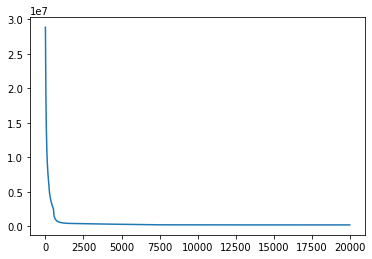

In [27]:
plt.plot(losses)

# check prediction and reconstruction

In [28]:
z = model.most_likely_states(data)

In [29]:
x_predict_arr = k_step_prediction(model, z, data)

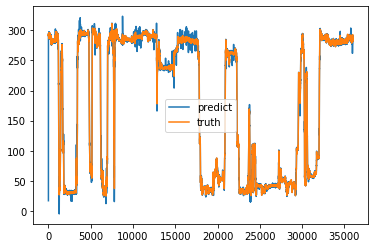

In [30]:
plt.plot(x_predict_arr[:,0], label='predict')
plt.plot(data[:,0].numpy(), label='truth')
plt.legend()
plt.show()

In [31]:
x_reconstruct = model.sample_condition_on_zs(z, data[0])

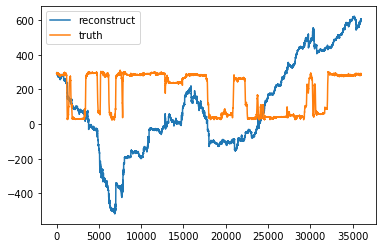

In [33]:
plt.plot(x_reconstruct[:,0], label='reconstruct')
plt.plot(data[:,0].numpy(), label='truth')
plt.legend()
plt.show()

reconstruction in this way (fixing the whole z-sequence) may not be a good idea.

# sample new data

In [34]:
sample_z, sample_x = model.sample(T)

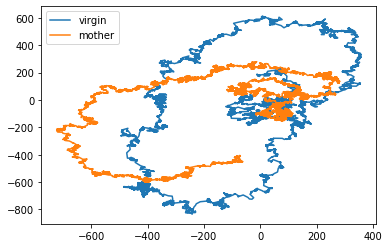

In [38]:
plt.plot(sample_x[:,0], sample_x[:,1], label='virgin')
plt.plot(sample_x[:,2], sample_x[:,3], label='mother')
plt.legend()
plt.show()

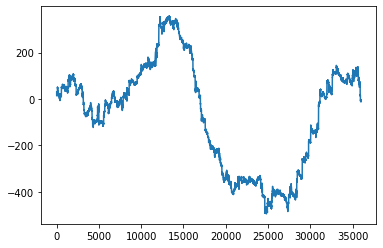

In [39]:
plt.plot(sample_x[:,0])

# try bigger starting lr = 0.01

In [54]:
K = 5
D = 4
T = 36000

tran_2 = LinearTransformation(K=K, d_in=D, d_out=D)
observation_2 = ARGaussianObservation(K=K, D=D, M=0, transformation=tran_2)

model_2 = HMM(K=K, D=D, M=0, observation=observation_2)

In [ ]:
num_iters = 20000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer_2 = torch.optim.Adam(model_2.params, lr=0.01)

losses_2 = []
for i in np.arange(num_iters):

    optimizer_2.zero_grad()

    loss_2 = model_2.loss(data)
    loss_2.backward(retain_graph=True)
    optimizer_2.step()
    losses_2.append(loss_2.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss_2))
        pbar.update(10)
        
pbar.close()

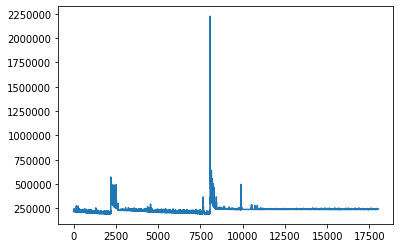

In [58]:
plt.plot(losses_2[2000:]);

In [59]:
losses_2[-1]

array(241133.71425236)

this learning rate is too large.

In [60]:
model.observation.mus_init

tensor([[15.3009, 13.8286, 15.4947, 15.6708],
        [ 0.0412,  1.0412,  0.0412,  0.0412],
        [ 0.0695,  0.0695,  1.0695,  0.0695],
        [ 0.0738,  0.0738,  0.0738,  1.0738],
        [ 4.5358,  4.3659,  5.6530,  5.5373]], dtype=torch.float64,
       requires_grad=True)

In [61]:
data[0]

tensor([292.9777, 324.8147,  78.2017,  75.1786], dtype=torch.float64)

In [62]:
model_2.observation.mus_init

tensor([[ 15.0601,  13.4339,  15.2350,  19.0030],
        [  0.1363,   1.1363,   0.1363,   0.1363],
        [ 13.4175,  12.7189,  20.2850,  19.2897],
        [ 83.4398, 100.1893,  78.2017,  75.1786],
        [ 24.3990,  25.4664,  29.4069,  24.7930]], dtype=torch.float64,
       requires_grad=True)